In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from xgboost import XGBClassifier

In [21]:
X = pd.read_csv("processed_data_sample.csv")
X.head()

,u,g,r,i,z,u-g,g-r,r-i,i-z,redshift,class
0,26.08505,20.82672,19.38475,18.48326,18.02336,5.2583,1.4420,0.9015,0.4599,0.540454,GALAXY
1,24.86864,22.46162,21.01175,19.94534,19.52274,2.4070,1.4499,1.0664,0.4226,0.677734,GALAXY
2,21.45235,21.42992,21.20718,20.98739,21.33426,0.0224,0.2227,0.2198,-0.3469,1.503873,QSO
3,22.09873,21.56069,21.54728,21.44752,20.83630,0.5380,0.0134,0.0998,0.6112,2.467196,QSO
4,19.69724,17.13469,15.92778,15.49672,15.24563,2.5626,1.2069,0.4311,0.2511,-0.000089,STAR


In [22]:
y = X.iloc[:, 10]
X = X.iloc[:, :-1]

In [23]:
X.dtypes

u           float64
g           float64
r           float64
i           float64
z           float64
u-g         float64
g-r         float64
r-i         float64
i-z         float64
redshift    float64
dtype: object

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
X_train.head()

,u,g,r,i,z,u-g,g-r,r-i,i-z,redshift
61513,23.87487,21.40682,19.62232,18.74603,18.40047,2.4681,1.7845,0.8763,0.3456,0.532426
64348,24.74919,23.43474,21.49532,20.38916,19.73051,1.3144,1.9394,1.1062,0.6587,0.557857
60794,22.65388,21.88643,21.68421,21.95739,22.65551,0.7675,0.2022,-0.2732,-0.6981,1.313105
78201,18.34046,16.93703,16.21426,15.80696,15.54754,1.4034,0.7228,0.4073,0.2594,0.076787
23186,23.01522,19.67538,18.15704,17.64683,17.26422,3.3398,1.5183,0.5102,0.3826,0.249379


In [26]:
y_train

61513    GALAXY
64348    GALAXY
60794       QSO
78201    GALAXY
23186    GALAXY
          ...  
22034    GALAXY
89794    GALAXY
31583    GALAXY
93479    GALAXY
19547    GALAXY
Name: class, Length: 80180, dtype: object

In [27]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test =  le.fit_transform(y_test)

In [28]:
pipeline = Pipeline([
    ("model", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss"
    ))
])

In [29]:
param_grid = {
    "model__max_depth":[4, 6, 8, 10],
    "model__learning_rate":[0.03, 0.05, 1]
}

In [30]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro"
)

In [31]:
grid.fit(X_train, y_train)

,estimator,"Pipeline(step...ass=3, ...))])"
,param_grid,"{'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [4, 6, ...]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [32]:
y_pred = grid.predict(X_test)

In [33]:
with open("results.txt", "w") as myfile:
    myfile.write(classification_report(y_test, y_pred))

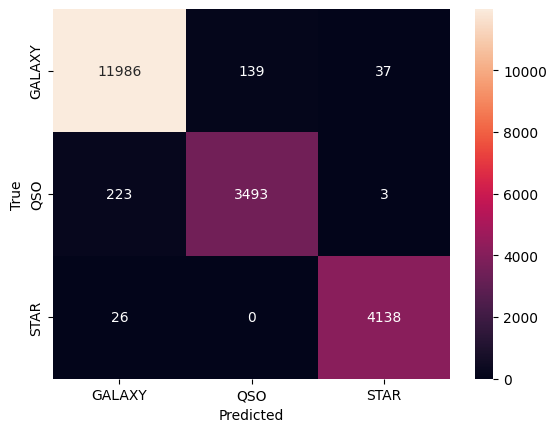

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")

In [37]:
with open("results.txt", "a") as myfile:
    myfile.write(f"\n\nbest parameters: {grid.best_params_}")
    myfile.write(f"best score: {grid.best_score_}")